# WOT-based analysis of mouse embryonic fibroblasts

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axisartist.axislines import AxesZero

import cellrank as cr
import scanpy as sc
import scvelo as scv
import wot

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
# set verbosity levels
cr.settings.verbosity = 4
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "realtime_kernel" / "mef", exist_ok=True)

In [5]:
TERMINAL_STATES = ["IPS", "Neural", "Stromal", "Trophoblast"]

## Function definitions

## Data loading

In [6]:
adata = cr.datasets.reprogramming_schiebinger(DATA_DIR / "mef" / "reprogramming_schiebinger.h5ad")
adata = adata[adata.obs["serum"] == "True"].copy()

adata.obs["day"] = adata.obs["day"].astype(float)
adata.uns["cell_sets_colors"] = sns.color_palette("colorblind").as_hex()[: len(adata.obs["cell_sets"].cat.categories)]

adata

DEBUG: Loading dataset from `'/vol/storage/philipp/code/cellrank2_reproducibility/data/mef/reprogramming_schiebinger.h5ad'`


AnnData object with n_obs × n_vars = 165892 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

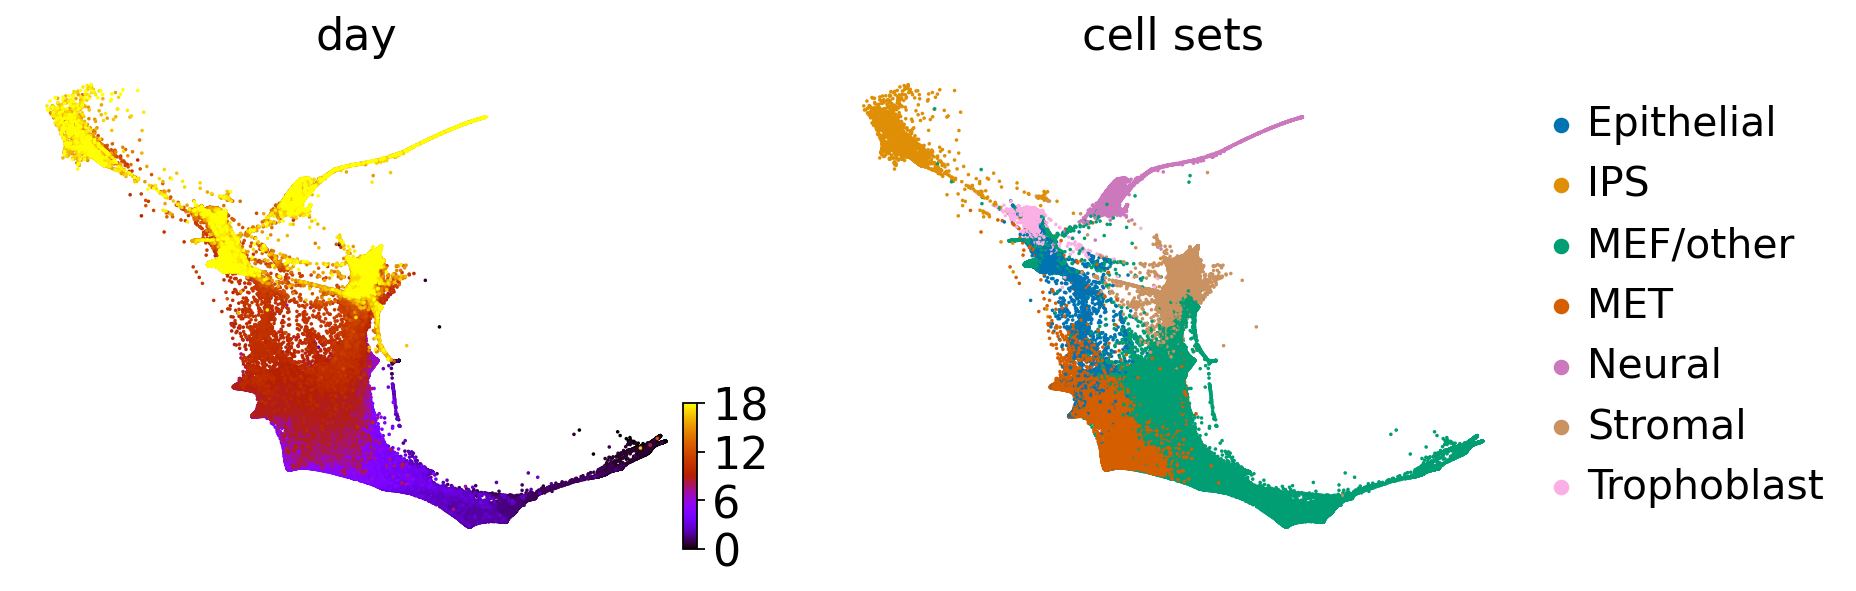

In [7]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "cell_sets"], legend_loc="right", cmap="gnuplot")

## Data pre-processing

In [8]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)


In [9]:
sc.pp.neighbors(adata, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:02:55)


## WOT

In [10]:
if not (DATA_DIR / "mef" / "wot_tmaps").exists():
    ot_model = wot.ot.OTModel(adata, day_field="day")
    ot_model.compute_all_transport_maps(tmap_out=DATA_DIR / "mef" / "wot_tmaps" / "tmaps")

In [11]:
cell_sets = {
    terminal_state: adata.obs_names[adata.obs["cell_sets"].isin([terminal_state])].tolist()
    for terminal_state in TERMINAL_STATES
}

In [12]:
tmap_model = wot.tmap.TransportMapModel.from_directory(DATA_DIR / "mef" / "wot_tmaps" / "tmaps")
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=18)

In [13]:
fate_ds = tmap_model.fates(target_destinations)

for terminal_state in TERMINAL_STATES:
    adata.obs[f"{terminal_state}_fate"] = fate_ds[:, terminal_state].X.squeeze()

#### Fate vs. experimental time

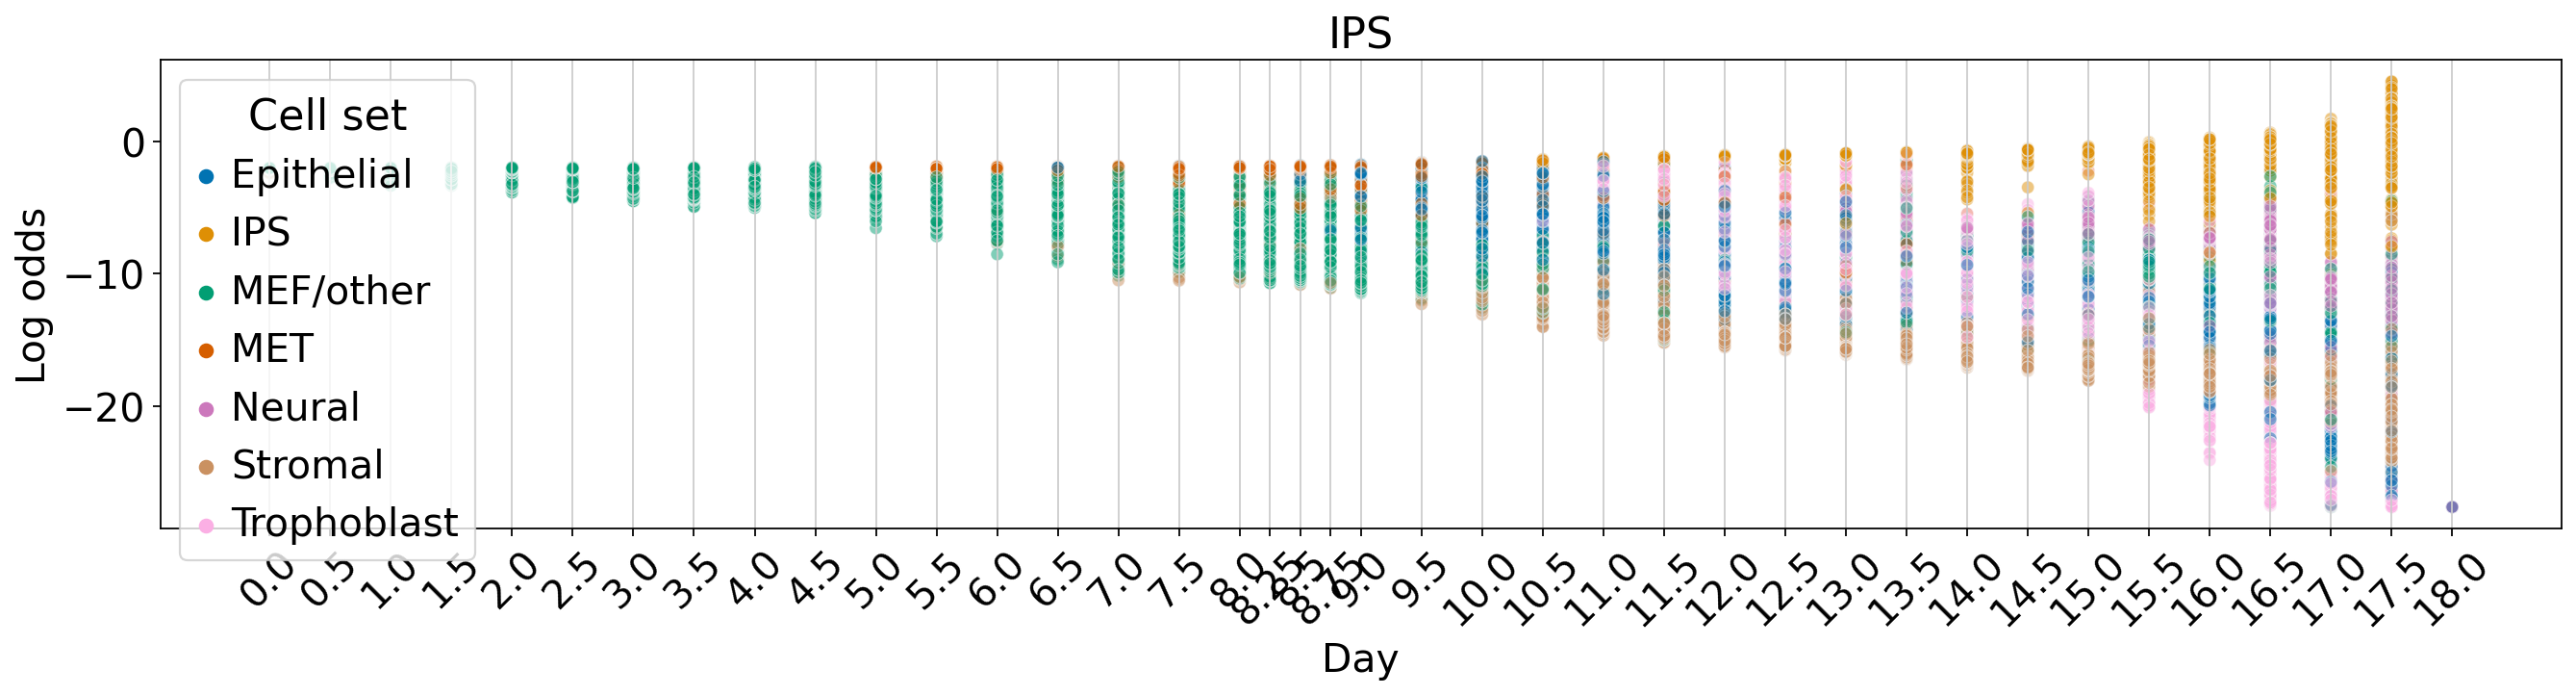

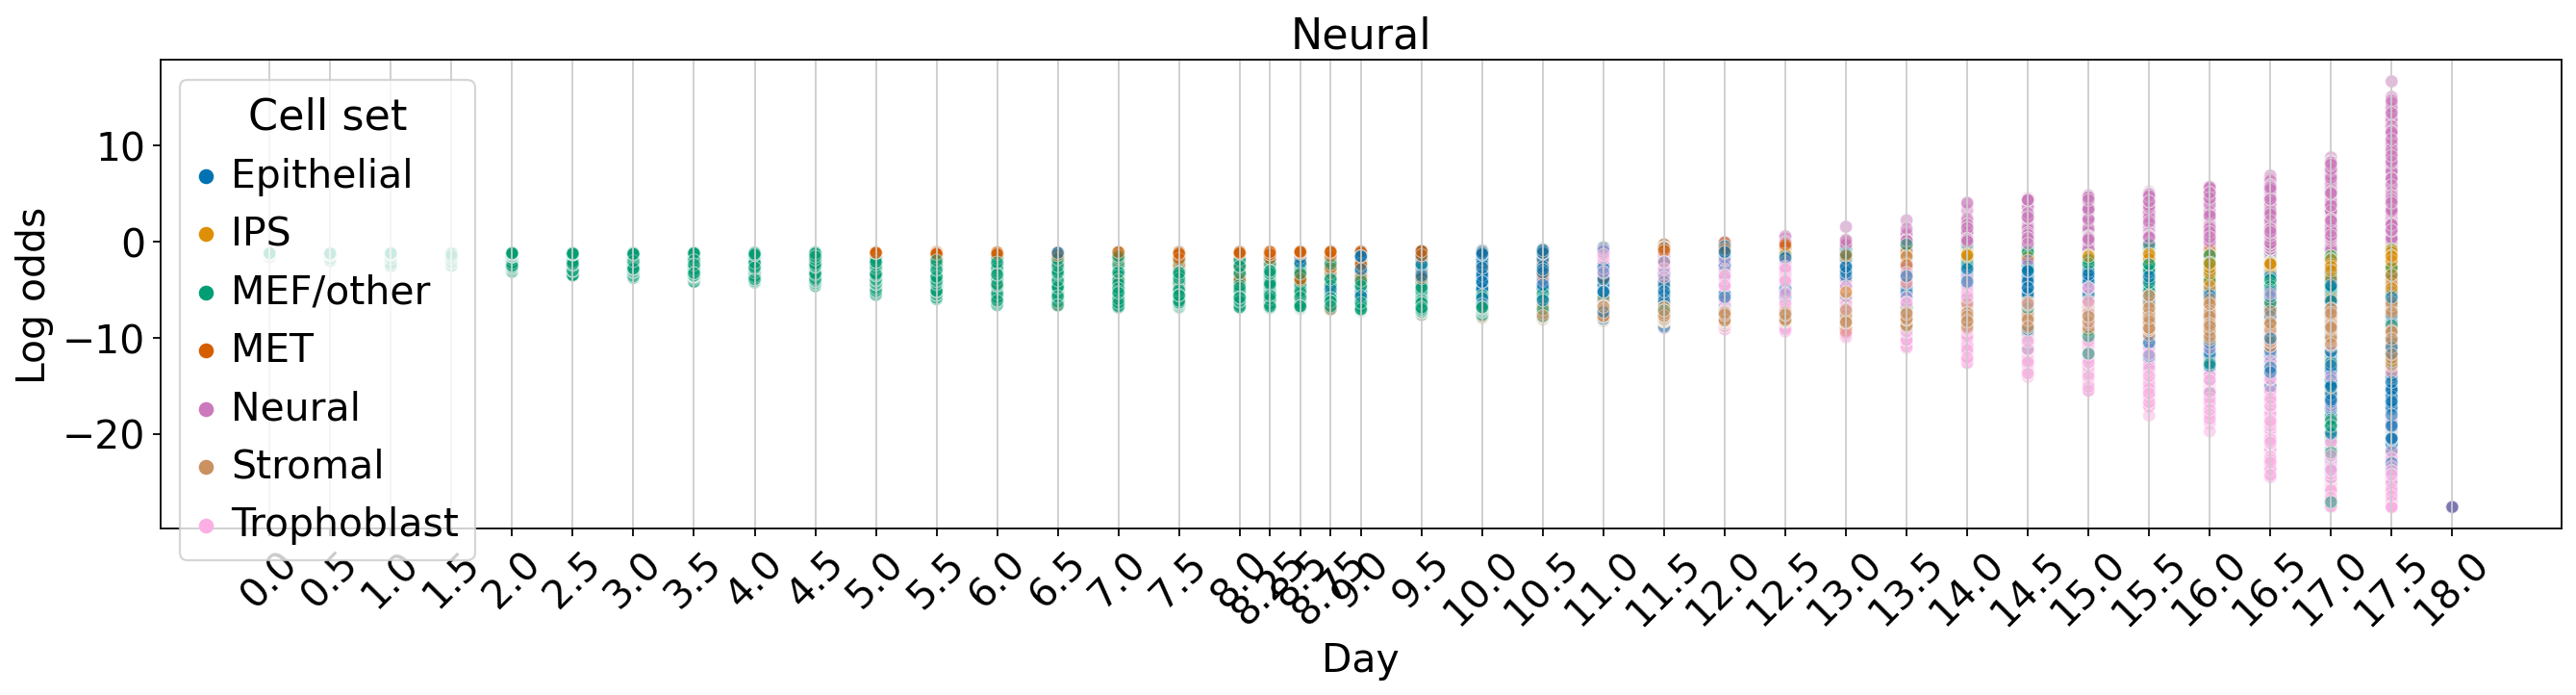

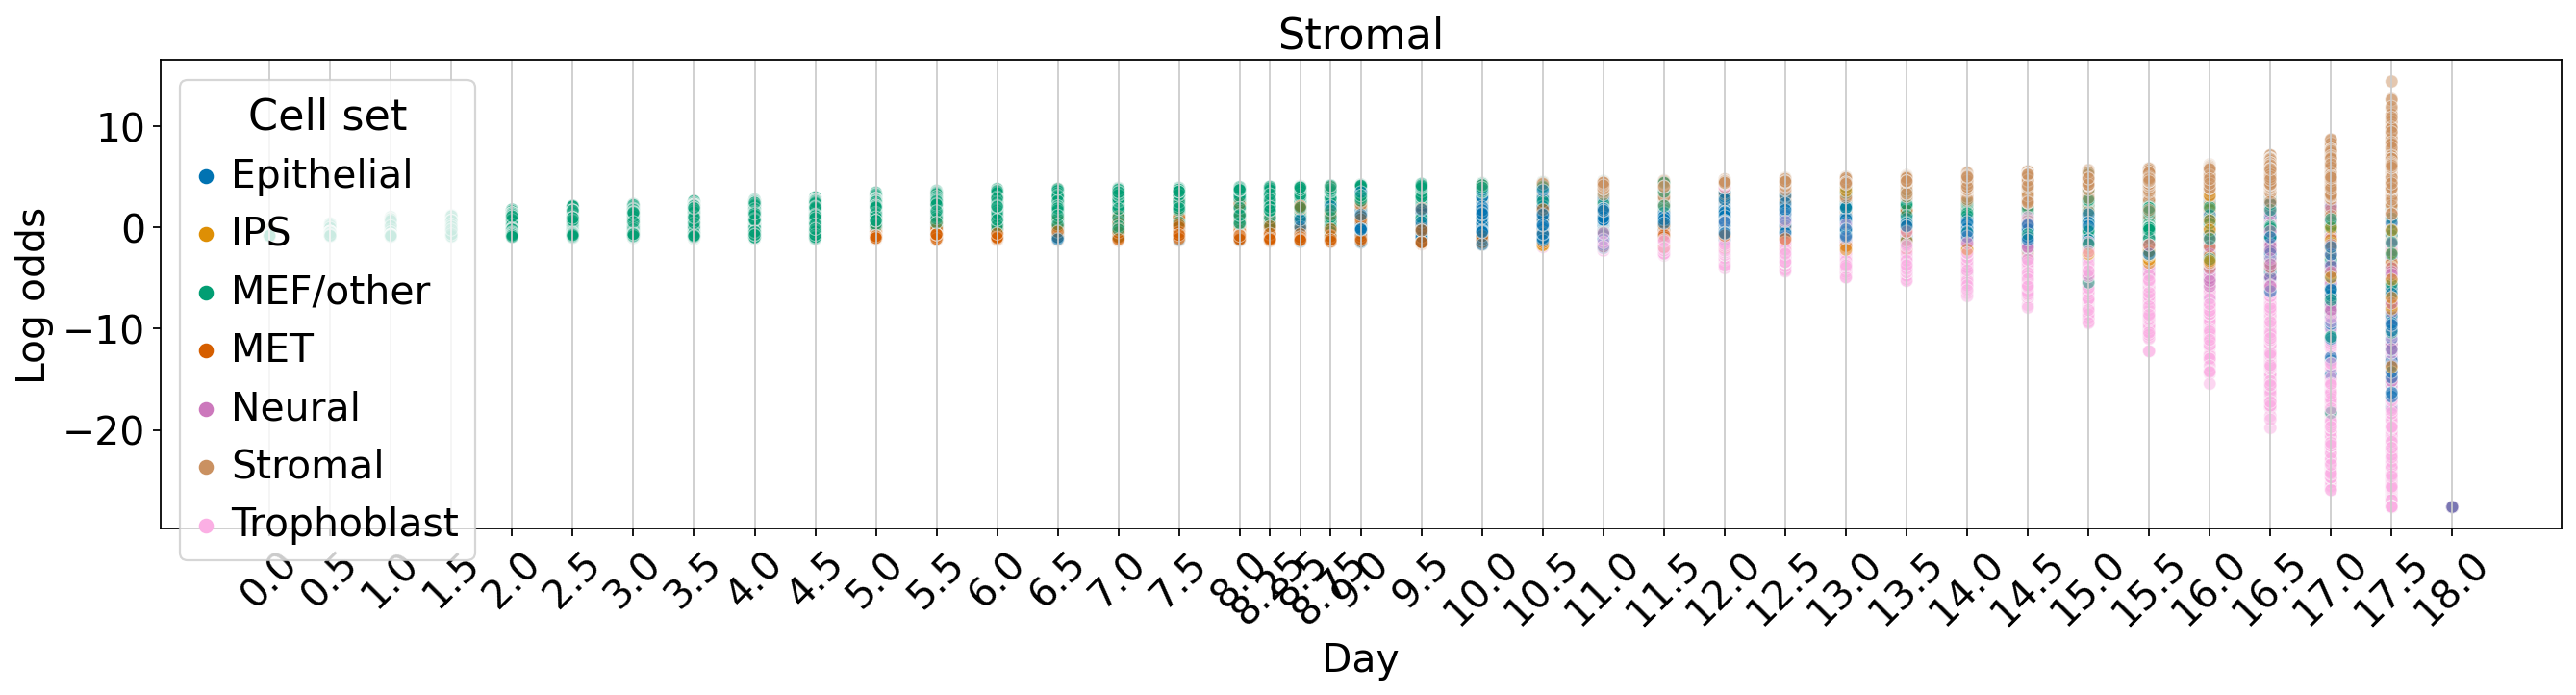

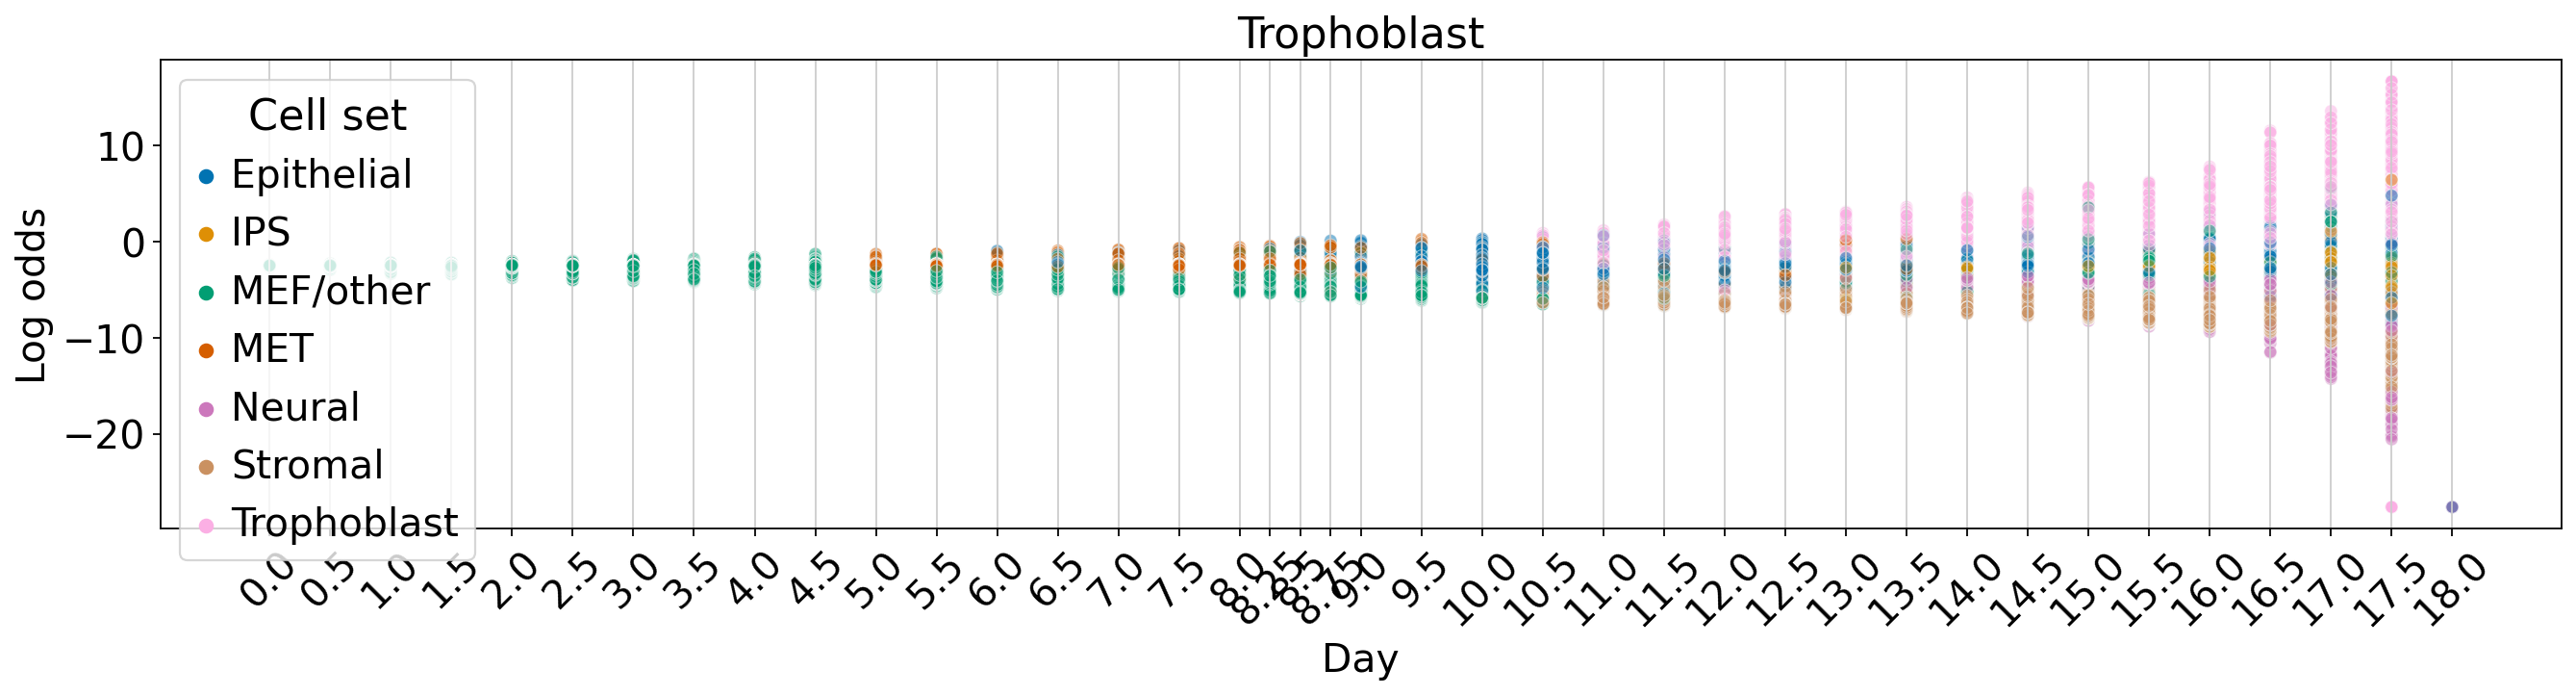

In [14]:
palette = dict(zip(adata.obs["cell_sets"].cat.categories, adata.uns["cell_sets_colors"]))

for terminal_state in TERMINAL_STATES:
    fate_prob = fate_ds[:, terminal_state].X.squeeze()
    ref_fate_prob = 1 - fate_prob
    log_odds = np.log(np.divide(fate_prob, 1 - fate_prob, where=fate_prob != 1, out=np.zeros_like(fate_prob)) + 1e-12)
    df = pd.DataFrame(
        {
            "Log odds": log_odds,
            "Day": adata.obs["day"].values,
            "Cell set": adata.obs["cell_sets"],
        }
    )

    fig, ax = plt.subplots(figsize=(20, 4))
    sns.scatterplot(data=df, x="Day", y="Log odds", hue="Cell set", alpha=0.5, palette=palette, ax=ax)

    ax.set_title(terminal_state)
    ax.xaxis.grid(True)
    ax.set_xticks(adata.obs["day"].unique())
    ax.set_xticklabels(ax.get_xticks(), rotation=45)

    if SAVE_FIGURES:
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(axes_class=AxesZero)

        for direction in ["xzero", "yzero"]:
            ax.axis[direction].set_axisline_style("-|>")
            ax.axis[direction].set_visible(True)
            ax.axis[direction].set_zorder(0)
        ax.axis["xzero"].set_ticklabel_direction("-")
        ax.axis["yzero"].set_ticklabel_direction("+")
        for direction in ["left", "right", "bottom", "top"]:
            ax.axis[direction].set_visible(False)

        sns.scatterplot(data=df, x="Day", y="Log odds", hue="Cell set", alpha=0.5, palette=palette, ax=ax)

        ax.xaxis.grid(True)
        ax.get_legend().remove()
        ax.set_xticks(ticks=adata.obs["day"].unique(), labels=[])
        ax.set_yticks(ticks=[-20, -10, 0, 10], labels=[])
        ax.set(xlabel=None, ylabel=None)

        fig.savefig(
            FIG_DIR / "realtime_kernel" / "mef" / f"wot_log_odds_vs_day-{terminal_state.lower()}_lineage.pdf",
            format="pdf",
            transparent=True,
            bbox_inches="tight",
            pad_inches=0.3,
        )

        plt.show()